# HW1
## Yidan Wang 2973331278

In [1]:
# load the data and packages

import pandas as pd
import numpy as np
import math
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")

data_file = '../data/vertebral_column_data/column_2C_weka.arff'
data, _ = arff.loadarff(data_file)
df = pd.DataFrame(data)
df["class"] = df["class"].str.decode('utf-8')

## (b) Pre-Processing and Exploratory data analysis

##### i. Make scatterplots of the independent variables in the dataset. Use color to show Classes 0 and 1.

##### ii. Make boxplots for each of the independent variables. Use color to show Classes 0 and 1 (see ISLR p. 129).

#### **From the plot, we can observe there is difference between Abnormal and Normal.**

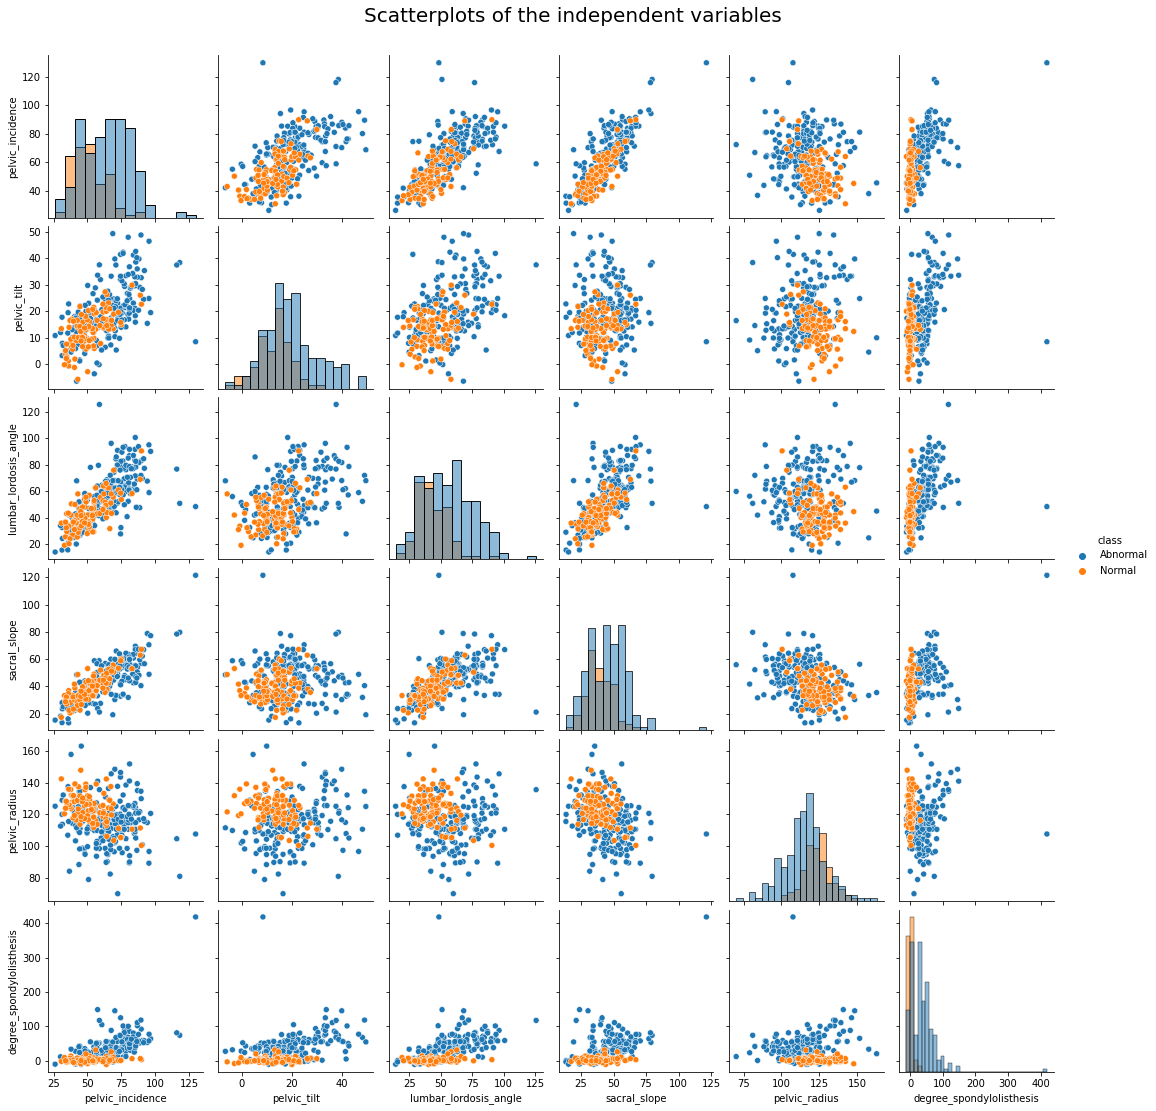

In [2]:
g1 = sns.pairplot(
    data=df, hue="class",
    kind="scatter", diag_kind="hist"
)
g1.fig.suptitle("Scatterplots of the independent variables", y=1.03, fontsize=20)
plt.show()

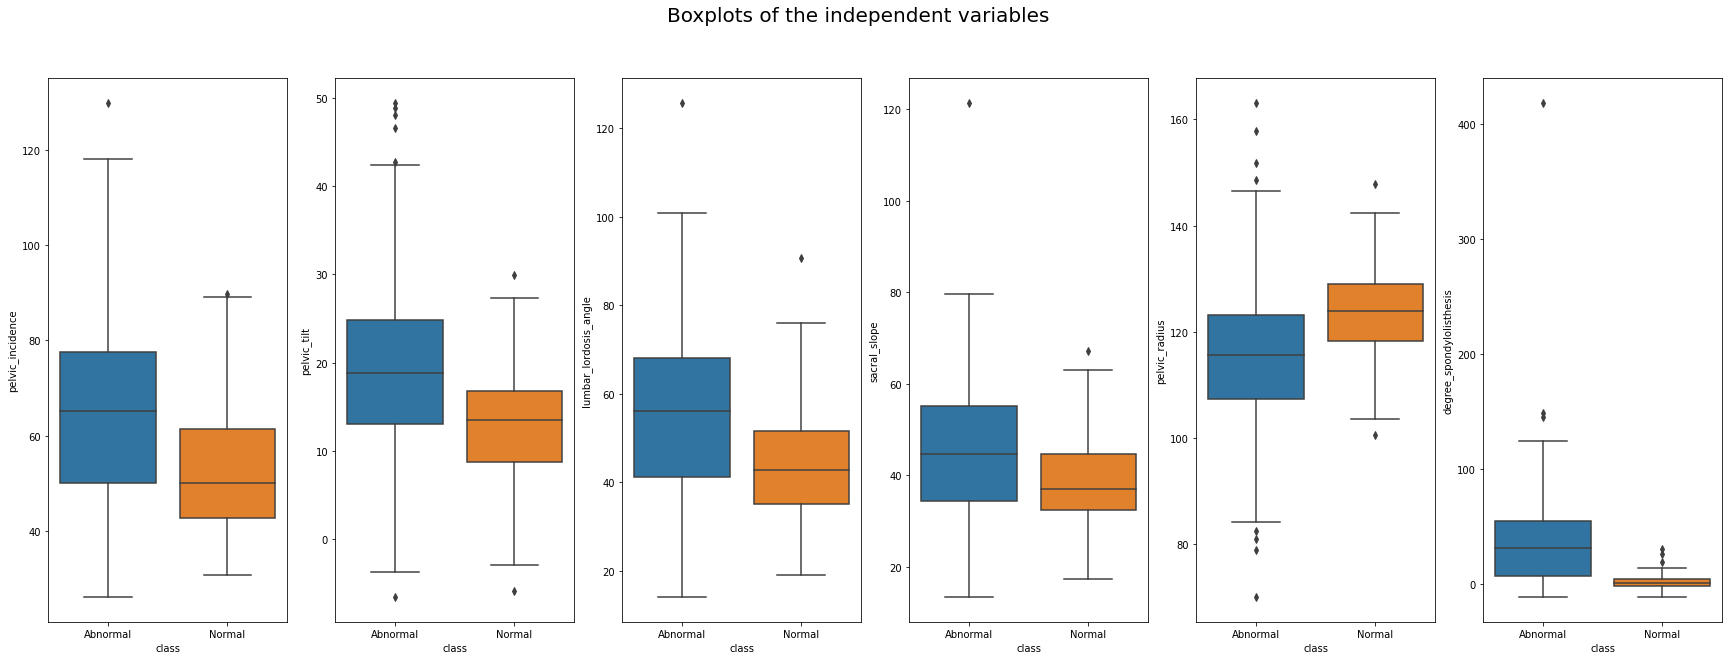

In [3]:
fig, ax =plt.subplots(1,6, figsize=(30,10))
variable_list = df.columns.tolist()[0:6]
fig.suptitle('Boxplots of the independent variables', fontsize=20)

for name, order in zip(variable_list, range(6)):
    sns.boxplot(y=name, x="class",
                data=df, ax=ax[order]);

#### iii. Select the ﬁrst 70 rows of Class 0 and the ﬁrst 140 rows of Class 1 as the training set and the rest of the data as the test set.

##### * If we do not label Normal and Abnormal with 0 and 1, the result will be kind of different when the numbers of abnormal and normal in nearest k points is the same. 
##### * If we do not label, the result will be Abnormal(A prefer than N), the false positive will decrease, while the false negative will imporve. 
##### * By stating 0 and 1, the result will be 0 (Normal), accuracy will improve.

In [4]:
data0 = df[df["class"]=='Normal']
data1 = df[df["class"]=='Abnormal']

# if not indicating that, when the probability is 50%, the result will be Abnormal(A prefer than N)
# By stating 0 and 1, the result will be 0 (Normal)
data11 = data1.copy()
data00 = data0.copy()
data11['class'].replace('Abnormal', 1, inplace=True)
data00['class'].replace('Normal', 0, inplace=True)

traindata = pd.concat((data11[0:140], data00[0:70]))
testdata = pd.concat((data11[140:], data00[70:]))


display(traindata)
display(testdata)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
...,...,...,...,...,...,...,...
275,67.289712,16.717514,51.000000,50.572198,137.591778,4.960344,0
276,51.325464,13.631223,33.258578,37.694240,131.306122,1.788870,0
277,65.756348,13.206926,44.000000,52.549422,129.393573,-1.982120,0
278,40.413366,-1.329412,30.982768,41.742778,119.335655,-6.173675,0


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
140,69.563486,15.401139,74.438497,54.162347,105.067356,29.701211,1
141,89.504947,48.903653,72.003423,40.601295,134.634291,118.353370,1
142,85.290173,18.278890,100.744220,67.011283,110.660701,58.884948,1
143,60.626217,20.595958,64.535262,40.030259,117.225554,104.859247,1
144,60.044177,14.309656,58.038865,45.734521,105.131664,30.409133,1
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0


## (c) Classiﬁcation using KNN on Vertebral Column Data Set

##### i. Write code for k-nearest neighbors with Euclidean metric (or use a software package).

##### ii. Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. Plot train and test errors in terms of k for k ∈ { 208, 205, . . . , 7, 4, 1, } (in reverse order). You are welcome to use smaller increments of k. Which k ∗ is the most suitable k among those values? Calculate the confusion matrix, true positive rate, true negative rate, precision,and F1 -score when k = k ∗ 

In [5]:
res_train = []
res_test = []
train_score_list = []
test_score_list = []


x_traindata = traindata.iloc[:,0:6]
y_traindata = traindata.iloc[:,-1]

x_testdata = testdata.iloc[:,0:6]
y_testdata = testdata.iloc[:,-1]

k_list = np.arange(1,208.1,3).astype(int).tolist()[::-1]

for k in k_list:
    # build knn model
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    # train
    knn.fit(x_traindata, y_traindata)
    
    # score = accuracy = 1 - error
    
    y_predict_train = knn.predict(x_traindata)
    y_predict_test = knn.predict(x_testdata)

    res_train.append(sum(~(y_predict_train == y_traindata))/210)
    res_test.append(sum(~(y_predict_test == y_testdata))/100)

    test_score_list.append(accuracy_score(y_testdata, y_predict_test))
    train_score_list.append(accuracy_score(y_traindata, y_predict_train))


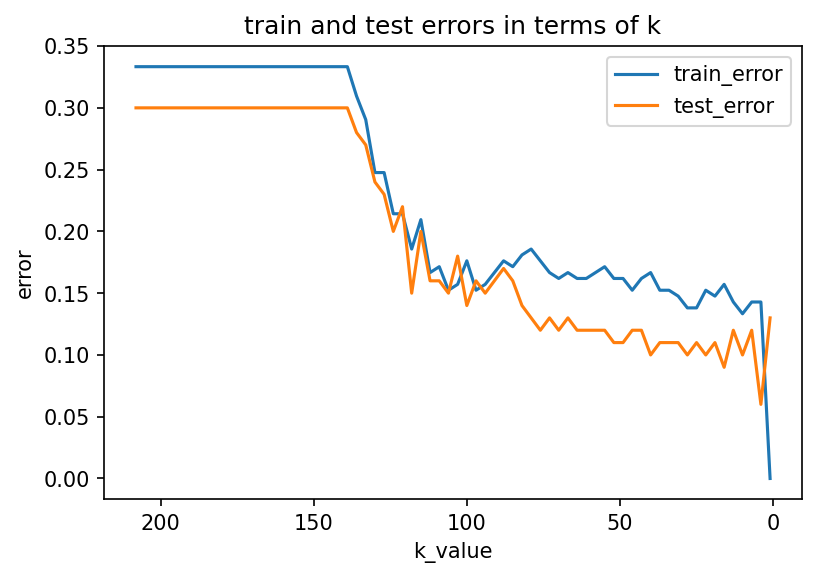

In [6]:
# plot the test error and train error

plt.figure(dpi=150)
plt.plot(k_list, res_train, label='train_error');
plt.plot(k_list, res_test, label='test_error');
plt.title("train and test errors in terms of k")
plt.gca().invert_xaxis()
plt.xlabel('k_value')
plt.ylabel('error')
plt.legend();

In [7]:
# find best K on the basis of mininize test error. find the smallest one if the test error is the same.

train_error_list = [1 - x for x in train_score_list]
test_error_list = [1 - x for x in test_score_list]

min_test_error = 1 - max(test_score_list)

maxindex = np.argwhere(test_score_list == np.amax(test_score_list)).flatten().tolist()
max_k_list = [k_list[x] for x in maxindex]
best_k = min(max_k_list) 
print("The best K is", best_k, "with test error is", min_test_error)

The best K is 4 with test error is 0.06000000000000005


#### The best K is 4 with test error is 0.06000000000000005

In [8]:
# build the model using the best K and analyse its performance

knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn.fit(x_traindata, y_traindata)

y_predict = knn.predict(testdata.iloc[:,0:6])

knn.score(x_testdata, y_testdata)


# AB=1 and NO=0
# my_confusion_matrix = confusion_matrix(y_testdata, y_predict, labels=["Normal", "Abnormal"])
my_confusion_matrix = confusion_matrix(y_testdata, y_predict)
cm_df = pd.DataFrame(my_confusion_matrix, columns=["predicted negative","predicted positive"], index=["Normal", "Abnormal"])
print("The Confusion Matrix is ")
print(cm_df)

# true positive rate, true negative rate, precision, F1
# tpr = TP/(TP+FN) = recall
tpr = my_confusion_matrix[1,1]/(my_confusion_matrix[1,1]+my_confusion_matrix[1,0])

# tnr = TN/(TN+FP)
tnr = my_confusion_matrix[0,0]/(my_confusion_matrix[0,0]+my_confusion_matrix[0,1])

#p = precision_score(y_testdata, y_predict, pos_label='Abnormal') 
#r = recall_score(y_testdata, y_predict, pos_label='Abnormal') 
#f1 = f1_score(y_testdata, y_predict, pos_label='Abnormal')  
p = precision_score(y_testdata, y_predict) 
r = recall_score(y_testdata, y_predict) 
f1 = f1_score(y_testdata, y_predict)   

print("The true positive rate is", tpr)
print("The true negative rate is", tnr)
print("Precision is", p)
print("F1-score is", f1)

The Confusion Matrix is 
          predicted negative  predicted positive
Normal                    25                   5
Abnormal                   1                  69
The true positive rate is 0.9857142857142858
The true negative rate is 0.8333333333333334
Precision is 0.9324324324324325
F1-score is 0.9583333333333333


##### iii. Since the computation time depends on the size of the training set, one may only use a subset of the training set. Plot the best test error rate, which is obtained by some value of k, against the size of training set, when the size of training set is N ∈ { 10, 20, 30, . . . , 210 }. 
##### Note: for each N, select your training set by choosing the ﬁrst ⌊ N/3 ⌋ rows of Class 0 and the ﬁrst N − ⌊ N/3 ⌋ rows of Class 1 in the training set you created in 1(b)iii. Also, for each N, select the optimal k from a set starting from k = 1, increasing by 5. For example, if N = 200, the optimal k is selected from { 1, 6, 11, . . . , 196 } . This plot is called a Learning Curve.

,Best_K,min_error_rate
N,,
10,1,0.25
20,6,0.20
30,1,0.22
40,11,0.25
50,26,0.30
60,21,0.29
70,26,0.29
80,31,0.29
90,41,0.29


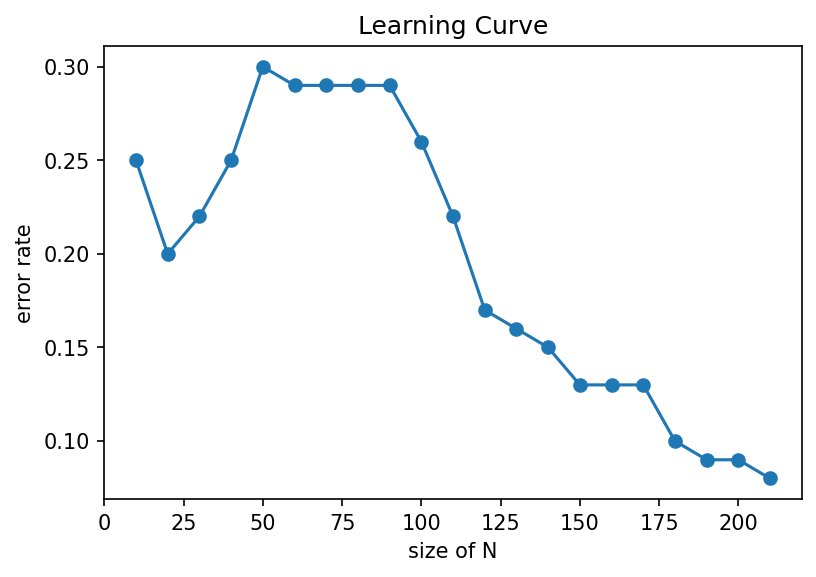

In [9]:
# learning curve

N_list = np.arange(10,210.1,10).astype(int).tolist()
best_K_c3 = []
min_error_rate_list = []

for n in N_list:
    k_list_c3 = np.arange(1,n+0.1,5).astype(int).tolist()[::-1]
    N0 = math.floor(n/3)
    N1 = n - math.floor(n/3)

    
    # traindata0 = traindata[traindata["class"]=='Normal'].iloc[0:N0, :]
    # traindata1 = traindata[traindata["class"]=='Abnormal'].iloc[0:N1, :]
    traindata0 = traindata[traindata["class"]== 0].iloc[0:N0, :]
    traindata1 = traindata[traindata["class"]== 1].iloc[0:N1, :]
    
    traindata_c3 = pd.concat([traindata0, traindata1])
    x_train_c3 = traindata_c3.iloc[:,0:6]
    y_train_c3 = traindata_c3.iloc[:,-1]
    
    test_score_list_c3 = []
    for k in k_list_c3:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(x_train_c3, y_train_c3)
        # score = accuracy = 1 - error
        test_score_list_c3.append(knn.score(x_testdata, y_testdata))
            
    best_error_rate = 1 - max(test_score_list_c3)
    min_error_rate_list.append(best_error_rate)
    maxindex = np.argwhere(test_score_list_c3 == np.amax(test_score_list_c3)).flatten().tolist()
    max_k_list = [k_list_c3[x] for x in maxindex]
    best_k = min(max_k_list) 
    best_K_c3.append(best_k)


lcdf = pd.DataFrame({"N":N_list, "Best_K":best_K_c3, "min_error_rate": min_error_rate_list})
lcdf.set_index('N',inplace=True)
display(lcdf)

plt.figure(dpi=150)
plt.plot(N_list, min_error_rate_list,"o-");
plt.title("Learning Curve")
plt.xlabel('size of N')
plt.ylabel('error rate');

## (d) Replace the Euclidean metric with the following metrics and test them. Summarize the test errors (i.e., when k = k ∗ ) in a table. Use all of your training data and select the best k when { 1, 6, 11, . . . , 196 } .

#### i. Minkowski Distance:

A. which becomes Manhattan Distance with p = 1.

B. with log 10 (p) ∈ { 0.1, 0.2, 0.3, . . . , 1 } . In this case, use the k ∗ you found for the Manhattan distance in 1(d)iA. What is the best log 10 (p)?

C. which becomes Chebyshev Distance with p → ∞

#### ii. Mahalanobis Distance


In [10]:
k_list_d = np.arange(1,196.1,5).astype(int).tolist()[::-1]

metric_list = ['manhattan', 'chebyshev', 'mahalanobis']
var_list = []
best_error_rate_list = []
best_k_list = []
best_k_dict = {}

for metric_name in metric_list:
    if metric_name == 'mahalanobis':
        test_score_list_d = []
        for k in k_list_d:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric_name, metric_params={'V': np.cov(x_traindata, rowvar=False)})
            knn.fit(x_traindata, y_traindata)
            test_score_list_d.append(knn.score(x_testdata, y_testdata))
        var_list.append(metric_name)
        best_error_rate_list.append(1-max(test_score_list_d))
        # print([1-x for x in test_score_list_d])
                                             
        maxindex = np.argwhere(test_score_list_d == np.amax(test_score_list_d)).flatten().tolist()
        max_k_list = [k_list_d[x] for x in maxindex]
        best_k_dict[metric_name] = max_k_list
        best_k = min(max_k_list) 
        best_k_list.append(best_k)
        
    else:
        test_score_list_d = []
        for k in k_list_d:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric_name)
            knn.fit(x_traindata, y_traindata)
            test_score_list_d.append(knn.score(x_testdata, y_testdata))                                    
        var_list.append(metric_name)
        best_error_rate_list.append(1-max(test_score_list_d))
                                     
        maxindex = np.argwhere(test_score_list_d == np.amax(test_score_list_d)).flatten().tolist()
        max_k_list = [k_list_d[x] for x in maxindex]
        best_k_dict[metric_name] = max_k_list
        best_k = min(max_k_list) 
        best_k_list.append(best_k)
                                     
            
d_table = pd.DataFrame({"matrix":var_list, "min_error_rate":best_error_rate_list, "best_k": best_k_list}) 
d_table.set_index('matrix',inplace=True)
display(d_table)


,min_error_rate,best_k
matrix,,
manhattan,0.11,1
chebyshev,0.08,16
mahalanobis,0.15,1


In [11]:
# B. find best P
origin_p_list = [ x/10 for x in list(range(1,11))]
best_k_manhattan = best_k_dict['manhattan']

my_dict = {}
for k in best_k_manhattan[::-1]:
    test_score_list_p = []
    for op in origin_p_list:
        p = math.pow(10,op)
        knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=p)
        knn.fit(x_traindata, y_traindata)
        test_score_list_p.append(1-knn.score(x_testdata, y_testdata))
    my_dict[k] = test_score_list_p
    
    
d3 = pd.DataFrame(my_dict)  
d3["log10(p)"] = origin_p_list
d3.set_index('log10(p)',inplace=True)
display(d3)

,1,6,11,26
log10(p),,,,
0.1,0.13,0.09,0.11,0.10
0.2,0.13,0.09,0.11,0.10
0.3,0.13,0.08,0.12,0.11
0.4,0.14,0.08,0.12,0.10
0.5,0.14,0.08,0.12,0.11
0.6,0.12,0.06,0.12,0.10
0.7,0.11,0.07,0.12,0.11
0.8,0.11,0.08,0.11,0.11
0.9,0.11,0.09,0.11,0.11


### Answer: 
#### If best K is 1, the best log10(p) is 0.7, 0.8, 0.9, 1.0 (test error: 0.11). 
#### IF the best K is 6, the best log10(p) is 0.6 (test error: 0.06)

## (e) The majority polling decision can be replaced by weighted decision, in which the weight of each point in voting is inversely proportional to its distance from the query/test data point. In this case, closer neighbors of a query point will have a greater inﬂuence than neighbors which are further away. Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors when k ∈ { 1, 6, 11, 16, . . . , 196 } .

In [ ]:
k_list_e = np.arange(1,196.1,5).astype(int).tolist()[::-1]

metric_list_e = ['euclidean', 'manhattan', 'chebyshev']
best_error_rate_list_distance = []
best_k_list_distance = []
for metric_name in metric_list_e:
    test_score_list_e = []
    for k in k_list_e:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric_name, weights="distance")
        knn.fit(x_traindata, y_traindata)
        test_score_list_e.append(knn.score(x_testdata, y_testdata))
    best_error_rate_list_distance.append(1-max(test_score_list_e))
        
    maxindex = np.argwhere(test_score_list_e == np.amax(test_score_list_e)).flatten().tolist()
    max_k_list = [k_list_e[x] for x in maxindex]
    best_k = min(max_k_list) 
    best_k_list_distance.append(best_k)

        
e_table = pd.DataFrame({"matrix":metric_list_e, "error_rate":best_error_rate_list_distance, "best_k": best_k_list_distance}) 
e_table.set_index('matrix',inplace=True)
display(e_table)     

## (f) What is the lowest training error rate you achieved in this homework?

#### The lowest test error rate is 0.06 when using Euclidean Distance as matrix and K = 4.
#### The lowest training error rate is 0 when k = 1.